In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

### Generate data

In [3]:
seq_len = 128
input_size = 1

In [4]:
def generate_normal_series(number, mean, seq_len):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        #length = scipy.stats.randint.rvs(50, 200)
        for l in range(seq_len):
            x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean, scale=1)
            x.append(x_curr)
            x_prev = x_curr
            label.append(0)
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels

def generate_anomaly_series(number, mean_old, mean_new, seq_len):
    data = []
    labels = []
    for i in range(number):
        x = []
        label = []
        x_prev = 0
        coef = 0.75
        #length = scipy.stats.randint.rvs(50, 200)
        chane_point = scipy.stats.randint.rvs(10, seq_len-20)
        for l in range(seq_len):
            if l < chane_point:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_old, scale=1)
                label.append(0)
                
            else:
                x_curr = coef*x_prev + (1 - coef)*norm.rvs(loc=mean_new, scale=1)
                label.append(1)
            x.append(x_curr)
            x_prev = x_curr
        data.append(np.asarray(x))
        labels.append(np.asarray(label))
    return data, labels


Generate train data

In [5]:
batch_size = 256


number_normal = batch_size*50
data_normal, labels_normal = generate_normal_series(number_normal, 0, seq_len)

In [6]:
def generate_several_anomaly_series(batch_size, number_anomaly, mean_old, mean_new_list, seq_len):
    data_anomaly = []
    labels_anomaly = []
    number_anomaly = number_anomaly*batch_size
    for mean_new in mean_new_list:
        tmp_data_anomaly, tmp_labels_anomaly = generate_anomaly_series(number_anomaly, mean_old, 
                                                                       mean_new, seq_len)
        data_anomaly.append(tmp_data_anomaly)
        labels_anomaly.append(tmp_labels_anomaly)
        
    return np.vstack(data_anomaly), np.vstack(labels_anomaly)

In [7]:
data_anomaly, labels_anomaly = generate_several_anomaly_series(batch_size, 5, 
                                                               0, [0.5, 1, 2.5, 5], seq_len)

In [8]:
for_train_data = np.vstack((data_normal, data_anomaly))
for_train_labels = np.vstack((labels_normal,labels_anomaly))

Generate test data

In [9]:
test_number_normal = batch_size*10
test_data_normal, test_labels_normal = generate_normal_series(test_number_normal, 0, seq_len)

In [10]:
test_data_anomaly, test_labels_anomaly = generate_several_anomaly_series(batch_size, 5, 
                                                                         0, [0.5, 1, 2.5, 5], seq_len)

In [11]:
test_data = np.vstack((test_data_normal, test_data_anomaly))
test_labels = np.vstack((test_labels_normal,test_labels_anomaly))

Split on train and val set:

In [12]:
train_data, val_data, train_labels, val_labels = train_test_split(for_train_data, for_train_labels, 
                                                                  test_size=0.2, shuffle=True,
                                                                  random_state=42)

#### Loss function

In [13]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n+1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n+1).to(device) * p_slice * cumprod  + (w + 1)*torch.prod(prod[1:])*(1 - p_slice[-1])
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [14]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):

            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.2
                loss[i] = alpha*loss_delay_detection(outputs[i, ind[0]: ind[0] + w], w) + (1 - alpha)*loss_false_alarms(outputs[i, :ind[0]])
        #print('Labels:', labels)
        #print('Loss:', loss)
        loss = torch.mean(loss)
        #print(loss)
        return loss

In [15]:
# input data parameters
input_size = 1
output_size = seq_len

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

In [16]:
def reshape_for_LSTM(data, seq_len, input_size):
    return data.reshape(data.shape[0], seq_len, input_size)

def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)
    
    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [17]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [18]:
device = torch.device("cuda:1")

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [20]:
model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CustomLoss()
#loss_function = torch.nn.BCELoss()

model.to(device)

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [21]:
epochs = 10
print_every = 500
valid_loss_min = np.Inf

loss_list = []
acc_list = []
counter = 0
model.train()

out_list = []
labels_list = []

for i in range(epochs):
    
    for inputs, labels in tqdm(train_loader):
        if inputs.shape[0] < batch_size:
            break
            
        counter += 1
        h = model.init_hidden(batch_size)
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)  
        


        # shape of lstm_in: [seq_len, batch_size, input_size]
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).

        output, h = model(inputs, h)
        loss = loss_function(output.squeeze(), labels.float())
        loss_list += [loss.cpu().clone().detach()]
        accuracy = (output > 0.5).long() == labels
        acc_list += [accuracy.cpu().detach().float().mean()]
        out_list.append(output.cpu().detach().float())
        labels_list.append(labels.cpu().detach().float())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if counter%print_every == 0:
            val_losses = []
            val_outputs = []
            model.eval()
            for val_inputs, val_labels in val_loader:
                if val_inputs.shape[0] < batch_size:
                    break
                val_h = model.init_hidden(batch_size)
                val_h = tuple([each.data for each in val_h])
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                
                val_out, val_h = model(val_inputs, val_h)
                val_loss = loss_function(val_out.squeeze(), val_labels.float())
                val_losses.append(val_loss.item())
                val_outputs += [val_out.cpu().clone().detach()]
                
            val_outputs_one = torch.cat(val_outputs, 0)
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
        

Epoch: 9/10... Step: 500... Loss: -37.421215... Val Loss: -36.389299



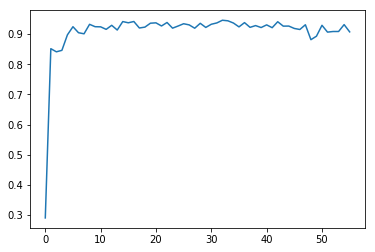

In [27]:
plt.plot(acc_list[::10])

In [28]:
def evaluate_metrics(y_true, y_pred):
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    ind_real = torch.where(y_true != y_true[0])[0]
    ind_detect = torch.where((y_pred > 0.5).long() != y_true[0])[0]

    if len(ind_real) > 0:
        real_change_ind = ind_real[0]

        if len(ind_detect) > 0:
            ind_sub_detect = torch.where(ind_detect > real_change_ind)[0]

            if len(ind_sub_detect) == len(ind_detect):
                detect_change_ind = ind_detect[0]
                delay = (detect_change_ind - real_change_ind).cpu().detach().numpy()
            else:
                false_positive += 1
        else:
            false_negative += 1

    else:
        if len(ind_detect) > 0:
            false_positive += 1
        else:
            true_negative += 1
    
    return false_positive, false_negative, delay

In [29]:
test_loss_list = []
test_acc_list = []

fp_list = []
fn_list = []
delay_list = []


model.eval()
for test_inputs, test_labels in test_loader:
    
    if test_inputs.shape[0] < batch_size:
        break
    test_h = model.init_hidden(batch_size)
    test_h = tuple([each.data for each in test_h])
    
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    test_output, test_h = model(test_inputs, test_h)
    test_loss = loss_function(test_output.squeeze(), test_labels.float())
    test_loss_list += [test_loss.cpu().clone().detach()]
    
    for i in range(0, batch_size):
        curr_output = test_output[i]
        curr_labels = test_labels[i]
        
        curr_fp, curr_fn, curr_delay = evaluate_metrics(curr_labels, curr_output)
        
        fp_list.append(curr_fp)
        fn_list.append(curr_fn)
        delay_list.append(curr_delay)
    
    accuracy = (test_output > 0.5).long() == test_labels
    test_acc_list += [accuracy.cpu().detach().float().mean()]

    
print("Test loss: {:.3f}".format(np.mean(test_loss_list)))
print("Test accuracy: {:.3f}%".format(np.mean(test_acc_list)))
print("Test delay: {:.2f}".format(np.mean(delay_list)))
print("Test FP: ", (np.sum(fp_list)))
print("Test FN: ", (np.sum(fn_list)))

Test loss: -17.939
Test accuracy: 0.867%
Test delay: 4.62
Test FP:  2707
Test FN:  114


In [25]:
np.mean(delay_list)

4.620442708333333

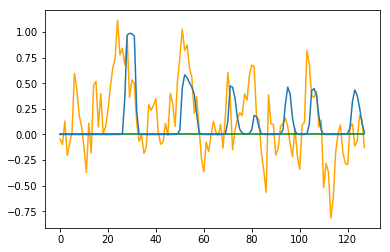

In [26]:
ind = 15
plt.plot(test_inputs[ind].cpu().detach().numpy(), color='orange')
plt.plot(test_labels[ind].cpu().detach().numpy(), color='green')
plt.plot(test_output[ind].cpu().detach().numpy())